<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_VQVAE_v2_(MSE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.5 MB/s eta 0:00:00


In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "vqvae_v2_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vqvae_v2_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
vqvae_v2_models.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import vqvae_v2_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB
from vqvae_v2_models import VQVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.91 GB


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))

9


In [16]:

# ---------------- Training Loop ----------------

# ハイパーパラメータ設定
epochs = 5000
interval = 100

model = VQVAE(n_dim=3, num_points=5000, embedding_dim=3, num_embeddings=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

rec_error_record = []
reg_error_record = []   # ここでは量子化損失を "reg" と呼んで記録
total_error_record = []
z_list = []

for epoch in range(epochs):
    model.train()
    running_rec_loss = 0.0
    running_quant_loss = 0.0
    running_total_loss = 0.0


    for batch_idx, (x,) in enumerate(data_loader):
        # -> [B, 3, 5000]
        x = x.permute(0, 2, 1).to(device)


        # 1) モデルの順伝搬
        # forward -> x_recon(B, num_points*3, 1), quant_loss, z(B, embedding_dim), embedding_dim
        x_recon_raw, quant_loss, z, _ = model(x)

        # 2) 再構成結果を decode() で [B, num_points, 3] に揃える
        #    あるいは forward() の出力を直接整形してもOK
        x_recon = model.decode(z)  # => [B, num_points, 3]

        # 3) 入力 x も [B, 3, num_points] なので、MSE をとるには同形にする
        #    permute(0,2,1) で [B, num_points, 3] に変形
        x_perm = x.permute(0, 2, 1)

        # 4) 再構成誤差 (MSE) を計算
        rec_loss = F.mse_loss(x_recon, x_perm)

        # 5) 全体の損失 = 再構成誤差 + 量子化損失
        loss = rec_loss + quant_loss

        # 6) 逆伝搬
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ロスを加算
        running_rec_loss += rec_loss.item()
        running_quant_loss += quant_loss.item()
        running_total_loss += loss.item()

        # 最終エポックなら z を保存
        if epoch == epochs - 1:
            z_list.append(z.cpu().detach().numpy())

    # バッチ数で割って平均を取る
    num_batches = batch_idx + 1
    epoch_rec_loss = running_rec_loss / num_batches
    epoch_quant_loss = running_quant_loss / num_batches
    epoch_total_loss = running_total_loss / num_batches

    rec_error_record.append(epoch_rec_loss)
    reg_error_record.append(epoch_quant_loss)
    total_error_record.append(epoch_total_loss)

    if epoch % interval == 0:
        print(f"[Epoch {epoch}/{epochs}] "
              f"Rec: {epoch_rec_loss}, Quant: {epoch_quant_loss}, Total: {epoch_total_loss}")

# 学習終了後、z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")


[Epoch 0/5000] Rec: 0.36439067125320435, Quant: 0.9791796455780665, Total: 1.343570311864217
[Epoch 100/5000] Rec: 0.056800340198808245, Quant: 0.0007620799911415412, Total: 0.057562420765558876
[Epoch 200/5000] Rec: 0.02126129248386456, Quant: 0.002357808204351386, Total: 0.023619100677832548
[Epoch 300/5000] Rec: 0.01725918904574226, Quant: 0.002547756154146757, Total: 0.019806944975344878
[Epoch 400/5000] Rec: 0.006804501185090178, Quant: 0.0031058761418939363, Total: 0.009910377234013544
[Epoch 500/5000] Rec: 0.00022911288195043907, Quant: 0.002046721873486806, Total: 0.0022758347238575677
[Epoch 600/5000] Rec: 0.018082159881790478, Quant: 0.004429813904506672, Total: 0.02251197387360864
[Epoch 700/5000] Rec: 0.0052700053137313164, Quant: 0.001680066294890518, Total: 0.006950071585985522
[Epoch 800/5000] Rec: 4.105075618099363e-05, Quant: 0.001097817077308605, Total: 0.001138867850664206
[Epoch 900/5000] Rec: 0.009134681177480767, Quant: 0.002548683449478833, Total: 0.0116833645281

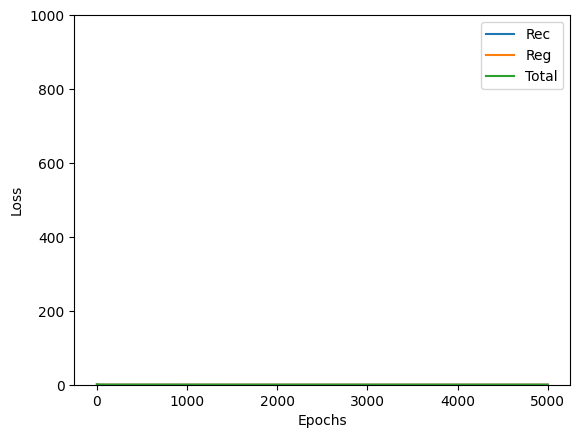

Model weights have been saved!


In [17]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(model.state_dict(), '/content/drive/MyDrive/chair/VQVAE_v2_Np5000_MSE_0302.pth')
print("Model weights have been saved!")

In [18]:
print(z_list) # z mu logvar

[array([[-0.09908243, -0.25984666, -0.0165326 ]], dtype=float32), array([[-0.07915135, -0.15696819, -0.16722366]], dtype=float32), array([[ 0.15592743,  0.04263853, -0.04480723]], dtype=float32), array([[-3.1350143e-02,  5.6968629e-03, -4.1874126e-05]], dtype=float32), array([[0.05687799, 0.03719245, 0.19752762]], dtype=float32), array([[0.08324502, 0.05610596, 0.11029582]], dtype=float32), array([[0.10551925, 0.03326949, 0.23123558]], dtype=float32), array([[ 0.09631834, -0.08614916, -0.21848436]], dtype=float32), array([[0.12834299, 0.04576736, 0.12796143]], dtype=float32)]


# 再構成形状の可視化

torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])


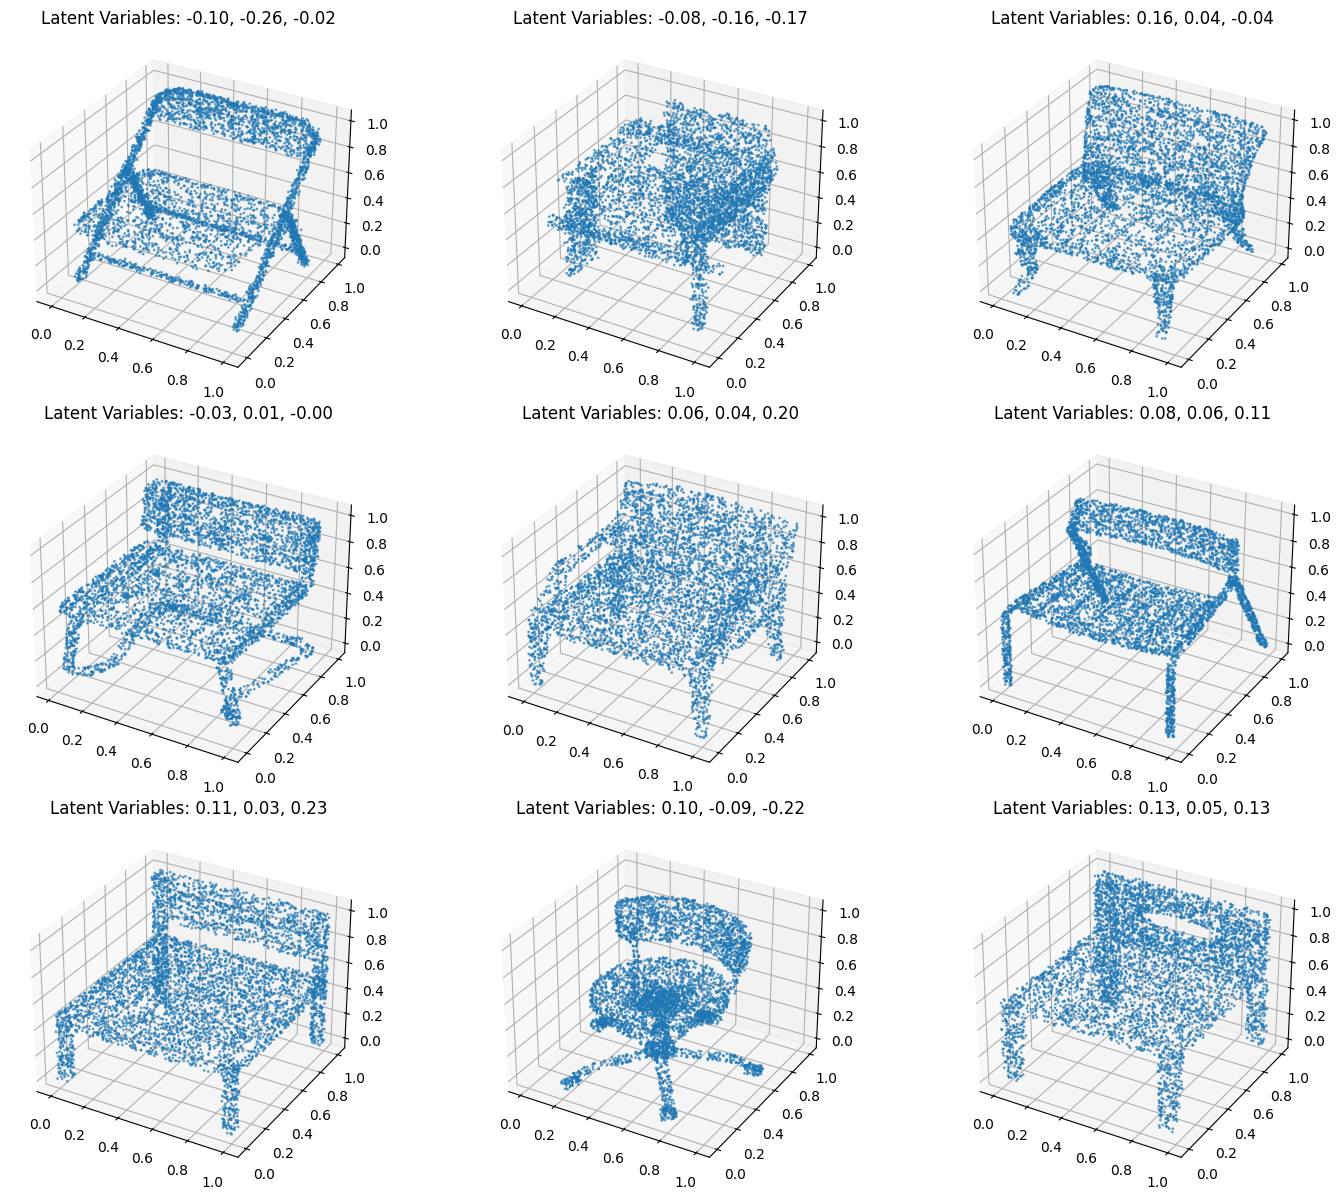

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = model.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

Chamfer Distances: [0.018792469054460526, 0.02080705016851425, 0.010530204512178898, 0.01299586147069931, 0.018770823255181313, 0.012105030938982964, 0.010559055022895336, 0.013498046435415745, 0.025788333266973495]
Average Chamfer Distance: 0.015982986013922427


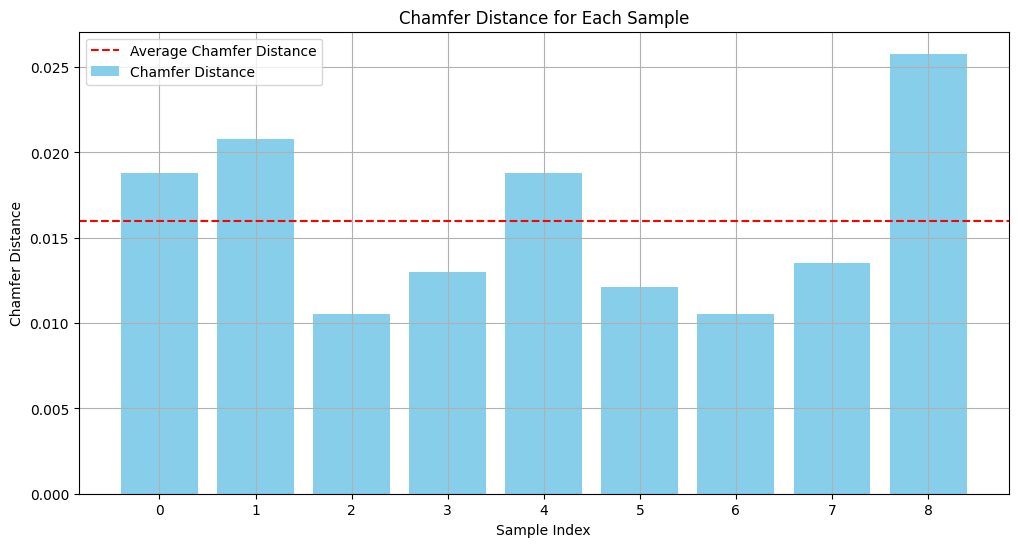

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

EMD Distances: [0.013467135712868953, 0.0115720242202946, 0.005485075686867756, 0.0068806435998296596, 0.010420337109033334, 0.00698428734354787, 0.005446757818811271, 0.007588804431193196, 0.015661345043951638]
Average EMD Distance: 0.009278490107377586


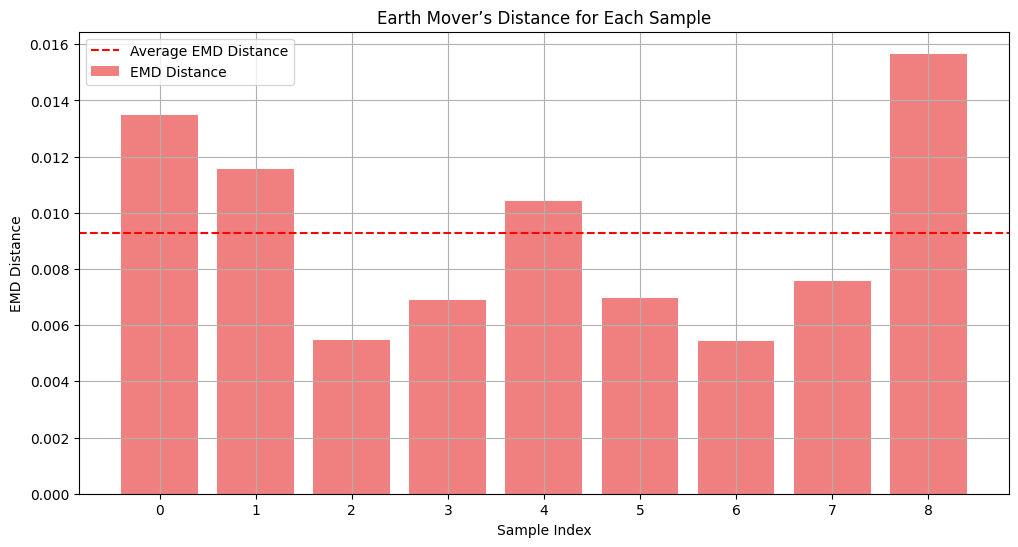

In [21]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
